In [5]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


In [6]:
training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform = None
)
test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor(),
)
image, label = training_data[0]
print(label)
print(image)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

9
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.

In [7]:
image.shape #Color_channels, height, width

torch.Size([1, 28, 28])

In [8]:
len(training_data.data), len(test_data.data) 

(60000, 10000)

T-shirt/top  - LABEL


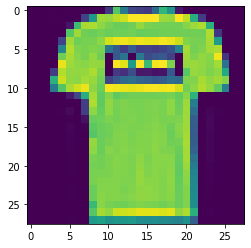

In [9]:
plt.imshow(training_data[1][0].squeeze())
print(training_data.classes[training_data[1][1]], " - LABEL")


In [10]:
#Dataloader to create batches on larger datasets
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(training_data, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = True)

train_features_batch, train_labels_batch = next(iter(train_dataloader))


In [11]:
class BaseLineCNN(nn.Module):
  def __init__(self,input_shape ,hidden_units, output_shape):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape, out_features = hidden_units),
        nn.Linear(in_features = hidden_units, out_features = output_shape)
    )
  def forward(self,X) :
      return self.layer_stack(X)

In [12]:
torch.manual_seed(42)

model_0 = BaseLineCNN(input_shape=784, # one for every pixel (28x28)
    hidden_units=10, # how many units in the hiden layer
    output_shape=len(training_data.classes) # one for every class
)
model_0.to("cpu") # keep model on CPU to begin with

BaseLineCNN(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.05)

In [14]:
from timeit import default_timer as timer


In [15]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 17.1 MB/s eta 0:00:00


In [16]:
from tqdm.auto import tqdm
from torchmetrics import Accuracy
torch.manual_seed(42)
train_time_start = timer()
epochs = 3

for epoch in tqdm(range(epochs)):
  print("EPOCH : ", epoch)
  train_loss = 0
  for batch, (X,y) in enumerate(train_dataloader):
    model_0.train()
    y_pred = model_0(X)
    #loss per batch
    loss = loss_fn(y_pred,y)
    #loss per epoch (across all batches)
    train_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(train_dataloader)
  test_loss, test_accuracy = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X,y in test_dataloader:
      test_pred = model_0(X)
      test_loss += loss_fn(test_pred,y)
      accuracy = Accuracy(task = "multiclass", num_classes = len(test_data.classes))
      test_accuracy += accuracy(test_pred.argmax(dim=1),y)
    test_loss /= len(test_dataloader)
    test_accuracy /= len(test_dataloader)
  print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_accuracy:.2f}%\n")

train_time_end_on_cpu = timer()
print("CPU TRAIN TIME : ", train_time_end_on_cpu - train_time_start)

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH :  0

Train loss: 0.62055 | Test loss: 0.50466, Test acc: 0.82%

EPOCH :  1

Train loss: 0.47309 | Test loss: 0.52063, Test acc: 0.82%

EPOCH :  2

Train loss: 0.44913 | Test loss: 0.47994, Test acc: 0.84%

CPU TRAIN TIME :  36.036426820999964


In [17]:
#Evaluation Function
torch.manual_seed(42)
accuracy_fn = Accuracy(task = "multiclass", num_classes = len(test_data.classes))
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_pred.argmax(dim=1),y) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results

{'model_name': 'BaseLineCNN',
 'model_loss': 0.47924771904945374,
 'model_acc': tensor(0.8375)}

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [19]:
class BaseLineCNNV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [20]:
torch.manual_seed(42)
model_1 = BaseLineCNNV2(input_shape=784, # number of input features
    hidden_units=10,
    output_shape=len(training_data.classes) # number of output classes desired
).to(device) # send model to GPU if it's available
next(model_1.parameters()).device # check model device

device(type='cuda', index=0)

In [21]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_pred.argmax(dim=1),y) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(test_pred.argmax(dim=1),y)
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [22]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn, 
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_pred.argmax(dim=1),y)
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [23]:
#Building a CNN
class CNNClassifier(nn.Module):
  def __init__(self,input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1), 
        nn.ReLU() ,
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)

    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, 3, padding = 1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

In [24]:
model_3 = CNNClassifier(1,10,len(training_data.classes)).to(device)